In [2]:
from Bio.Blast import NCBIXML
from os import listdir
import pandas as pd

def edit_xmltype(path):
    edit = open(path).read().replace("BlastOutput2","BlastXML2")
    open(path,"w").write(edit)

def find_mutations(hsp):
    hsp_mutations = []
    start = hsp.sbjct_start
    for i, (q, s) in enumerate(zip(hsp.query,hsp.sbjct)):
        if q.lower() != s.lower():
            hsp_mutations.append([q,start+i,s])
    return hsp_mutations

pct_identities = []
df = pd.DataFrame(columns=["file","protein","mutations"])
files = listdir("./BLAST_OUT/XML/")[1:]
for i,xml_filename in enumerate(files):
    print(f"Progress: {100*i/len(files):.2f}%",end="\r")
    path_fmt = f"./BLAST_OUT/XML/{xml_filename}"
    edit_xmltype(path_fmt)
    record = NCBIXML.read(open(path_fmt))
    for description,alignment in zip(record.descriptions,record.alignments):
        record_mutations = []
        for hsp in alignment.hsps:
            pct_identity = hsp.identities/hsp.align_length
            pct_identities.append(pct_identity)
            if pct_identity >= 0.95 and pct_identity < 1:
                record_mutations.extend(find_mutations(hsp))
        df.loc[len(df),:] = [xml_filename,description.title,record_mutations]
df["n_mutations"] = df.mutations.apply(lambda x: len(x))

C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


In [3]:
df.sort_values(by="n_mutations",ascending=False)

,file,protein,mutations,n_mutations
260,BLAST_171.xml,cds-YP_009724390.1; gene-GU280_gp02; Genbank:Y...,"[[H, 173, Q], [P, 307, T], [G, 614, D], [H, 67...",41
263,BLAST_172.xml,cds-YP_009724390.1; gene-GU280_gp02; Genbank:Y...,"[[S, 225, P], [F, 229, L], [L, 231, I], [C, 79...",20
226,BLAST_161.xml,cds-YP_009724390.1; gene-GU280_gp02; Genbank:Y...,"[[G, 575, A], [R, 580, Q], [F, 605, S], [F, 87...",16
229,BLAST_162.xml,cds-YP_009724390.1; gene-GU280_gp02; Genbank:Y...,"[[H, 14, Q], [N, 529, K], [F, 530, S], [N, 531...",15
238,BLAST_165.xml,cds-YP_009724390.1; gene-GU280_gp02; Genbank:Y...,"[[N, 77, K], [L, 106, F], [H, 115, Q], [G, 130...",14
...,...,...,...,...
255,BLAST_17.xml,cds-YP_009724389.1; gene-GU280_gp01; Genbank:Y...,[],0
256,BLAST_17.xml,cds-YP_009724390.1; gene-GU280_gp02; Genbank:Y...,[],0
258,BLAST_170.xml,cds-YP_009725295.1; gene-GU280_gp01; Genbank:Y...,[],0
259,BLAST_170.xml,cds-YP_009724389.1; gene-GU280_gp01; Genbank:Y...,[],0


In [4]:
from itertools import chain
protein_df = pd.DataFrame(df.groupby("protein").n_mutations.sum()).sort_values(by="n_mutations",ascending=False)
protein_df["mutations"] = None
for i,protein in enumerate(protein_df.index):
    protein_mutations = []
    protein_rows = df.loc[df.protein == protein,"mutations"]
    for row in protein_rows:
        protein_mutations.extend(row)
    protein_mutations = ["".join([str(i) for i in protein_mutation]) for protein_mutation in protein_mutations]
    protein_mutations = list(set(protein_mutations))
    protein_df.loc[protein,:] = [protein_df.loc[protein,"n_mutations"],protein_mutations]
protein_df["n_unique_mutations"] = protein_df.mutations.apply(lambda x: len(x))
protein_df["shorthand"] = [i.split(";")[-2] for i in protein_df.index]
protein_df

C:\Users\Ryan\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,n_mutations,mutations,n_unique_mutations,shorthand
protein,,,,
cds-YP_009724390.1; gene-GU280_gp02; Genbank:YP_009724390.1; YP_009724390.1; structural protein; spike protein; CDS; S; GU280_gp02; surface glycoprotein; YP_009724390.1,277,"[S274T, L1103F, S802F, N380Y, A798G, X1101H, P...",210,surface glycoprotein
cds-YP_009724397.2; gene-GU280_gp10; Genbank:YP_009724397.2; YP_009724397.2; ORF9; structural protein; CDS; N; GU280_gp10; nucleocapsid phosphoprotein; YP_009724397.2,11,"[n202S, L326P, r204G, k203R, I210M, l187S, V211A]",7,nucleocapsid phosphoprotein
cds-YP_009724396.1; gene-GU280_gp09; Genbank:YP_009724396.1; YP_009724396.1; CDS; ORF8; GU280_gp09; ORF8 protein; YP_009724396.1,9,[S84L],1,ORF8 protein
cds-YP_009724389.1; gene-GU280_gp01; Genbank:YP_009724389.1; YP_009724389.1; pp1ab; translated by -1 ribosomal frameshift; ribosomal slippage; CDS; ORF1ab; GU280_gp01; ORF1ab polyprotein; YP_009724389.1,7,"[N1571K, V1542L, L314P, T1603A, D1642V, D1615V]",6,ORF1ab polyprotein
cds-YP_009725295.1; gene-GU280_gp01; Genbank:YP_009725295.1; YP_009725295.1; pp1a; CDS; ORF1ab; GU280_gp01; ORF1a polyprotein; YP_009725295.1,4,"[X78T, R4330C]",2,ORF1a polyprotein
cds-YP_009724393.1; gene-GU280_gp05; Genbank:YP_009724393.1; YP_009724393.1; ORF5; structural protein; CDS; M; GU280_gp05; membrane glycoprotein; YP_009724393.1,2,"[V57L, R89G]",2,membrane glycoprotein
cds-YP_009724394.1; gene-GU280_gp06; Genbank:YP_009724394.1; YP_009724394.1; CDS; ORF6; GU280_gp06; ORF6 protein; YP_009724394.1,1,[V46E],1,ORF6 protein
cds-YP_009724391.1; gene-GU280_gp03; Genbank:YP_009724391.1; YP_009724391.1; CDS; ORF3a; GU280_gp03; ORF3a protein; YP_009724391.1,0,[],0,ORF3a protein
cds-YP_009724392.1; gene-GU280_gp04; Genbank:YP_009724392.1; YP_009724392.1; ORF4; structural protein; E protein; CDS; E; GU280_gp04; envelope protein; YP_009724392.1,0,[],0,envelope protein


<AxesSubplot:ylabel='Count'>

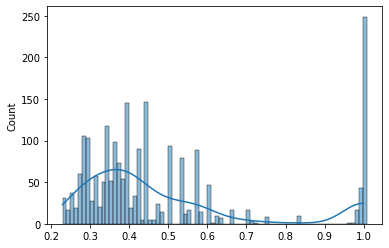

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
sns.histplot(pct_identities,kde=True,binwidth=0.01,ax=ax)

In [7]:
outfile = "./mutation_list.csv"

with open(outfile,"w") as f:
    f.write("PROTEIN,AA1LOCATIONAA2\n")
    for i,row in protein_df.iterrows():
        for mutation in row.mutations:
            f.write(row.shorthand.strip() + "," + mutation +"\n")

In [8]:
mutations_df = pd.DataFrame(columns=["file","protein","aa1","location","aa2","mutation_shorthand"])

protein_counts = {}
files = listdir("./BLAST_OUT/XML/")[1:]
for i,xml_filename in enumerate(files):
    print(f"Progress: {100*i/len(files):.2f}%",end="\r")
    path_fmt = f"./BLAST_OUT/XML/{xml_filename}"
    edit_xmltype(path_fmt)
    record = NCBIXML.read(open(path_fmt))
    for description,alignment in zip(record.descriptions,record.alignments):
        protein_name = description.title.split(";")[-2].strip()
        try:
            protein_counts[protein_name] += 1
        except:
            protein_counts[protein_name] = 1
        for hsp in alignment.hsps:
            pct_identity = hsp.identities/hsp.align_length
            if pct_identity >= 0.95 and pct_identity < 1:
                for mutation in find_mutations(hsp):
                    mutations_df.loc[len(mutations_df),:] = [xml_filename,protein_name,*mutation,"".join([str(i) for i in mutation])]
mutations_df

,file,protein,aa1,location,aa2,mutation_shorthand
0,BLAST_107.xml,surface glycoprotein,G,614,D,G614D
1,BLAST_110.xml,surface glycoprotein,D,496,G,D496G
2,BLAST_110.xml,surface glycoprotein,G,614,D,G614D
3,BLAST_125.xml,ORF8 protein,S,84,L,S84L
4,BLAST_130.xml,surface glycoprotein,G,614,D,G614D
...,...,...,...,...,...,...
306,BLAST_90.xml,ORF8 protein,S,84,L,S84L
307,BLAST_92.xml,ORF8 protein,S,84,L,S84L
308,BLAST_93.xml,ORF8 protein,S,84,L,S84L
309,BLAST_94.xml,ORF8 protein,S,84,L,S84L


In [9]:
mutation_freqs_df = pd.DataFrame()
mutation_freqs_df["mutation_shorthand"] = mutations_df.mutation_shorthand.unique()
mutation_freqs_df["aa1"] = mutation_freqs_df.mutation_shorthand.apply(lambda x: x[0])
mutation_freqs_df["aa2"] = mutation_freqs_df.mutation_shorthand.apply(lambda x: x[-1])
mutation_freqs_df["location"] = mutation_freqs_df.mutation_shorthand.apply(lambda x: x[1:-1])
for protein in protein_counts:
    mutation_freqs_df[protein] = None
    protein_df_ = mutations_df.loc[mutations_df.protein == protein,:]
    for i, row in mutation_freqs_df.iterrows():
        protein_mutation_df_ = protein_df_.loc[protein_df_.mutation_shorthand == row.mutation_shorthand,:]
        mutation_freqs_df.loc[i,protein] = len(protein_mutation_df_)/protein_counts[protein]
mutation_freqs_df = mutation_freqs_df.drop(columns=[column for column in mutation_freqs_df.columns[4:] if sum(mutation_freqs_df[column]) == 0])

In [10]:
mutation_freqs_df

,mutation_shorthand,aa1,aa2,location,ORF1ab polyprotein,surface glycoprotein,ORF1a polyprotein,nucleocapsid phosphoprotein,membrane glycoprotein,ORF8 protein,ORF6 protein
0,G614D,G,D,614,0.0,0.131148,0.0,0.000000,0.000000,0.00,0.0
1,D496G,D,G,496,0.0,0.005464,0.0,0.000000,0.000000,0.00,0.0
2,S84L,S,L,84,0.0,0.000000,0.0,0.000000,0.000000,0.36,0.0
3,Q1144E,Q,E,1144,0.0,0.005464,0.0,0.000000,0.000000,0.00,0.0
4,k203R,k,R,203,0.0,0.000000,0.0,0.056604,0.000000,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
224,V57L,V,L,57,0.0,0.000000,0.0,0.000000,0.071429,0.00,0.0
225,R89G,R,G,89,0.0,0.000000,0.0,0.000000,0.071429,0.00,0.0
226,V46E,V,E,46,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.5
227,V701A,V,A,701,0.0,0.005464,0.0,0.000000,0.000000,0.00,0.0


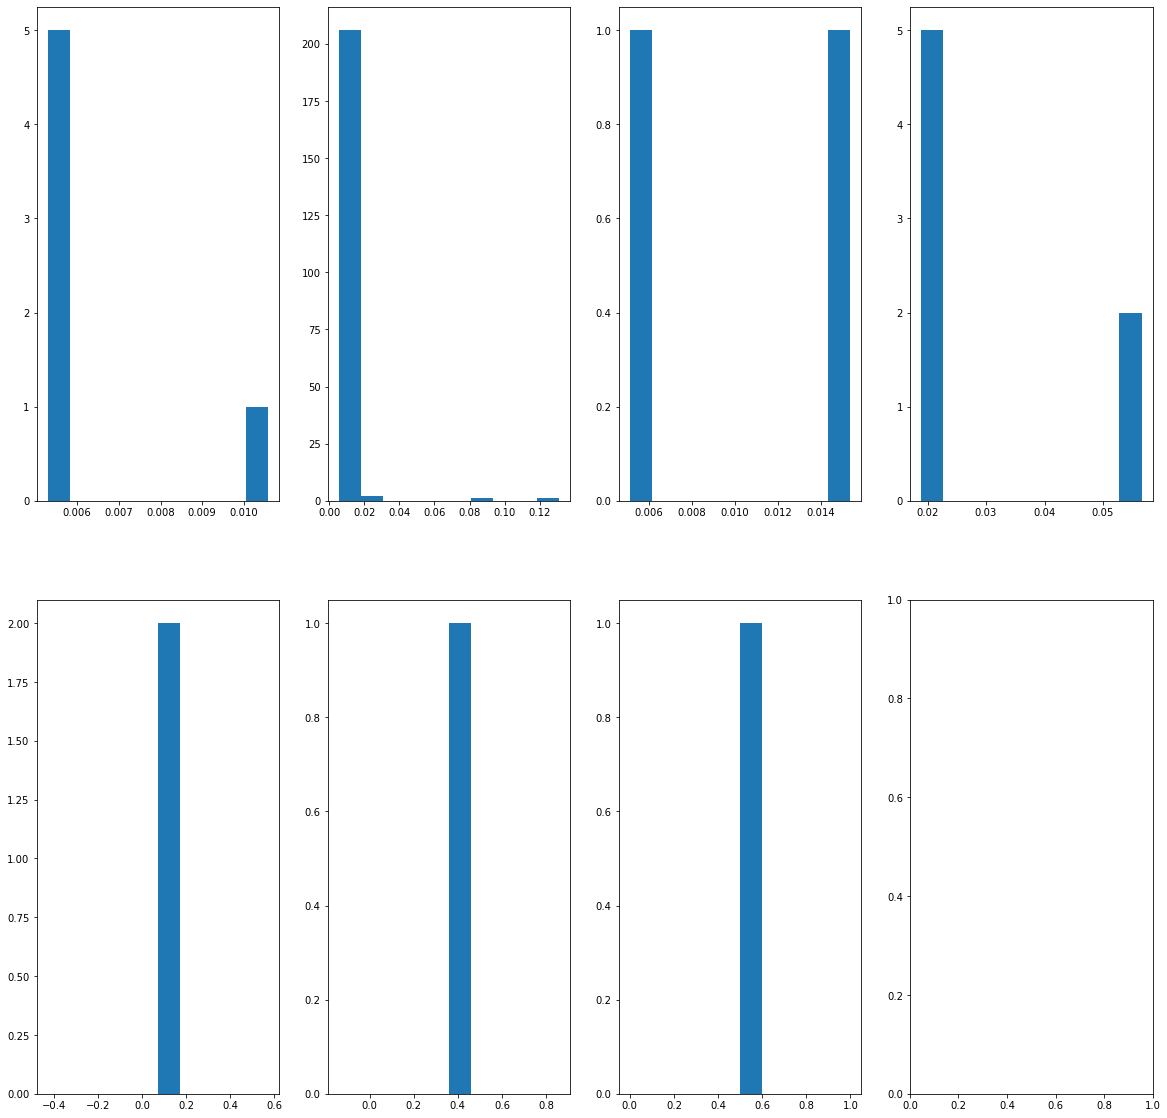

In [11]:
fig, axes = plt.subplots(2,4,figsize=(20,20))
for protein,ax in zip(mutation_freqs_df.columns[4:],axes.flatten()):
    ax.hist(mutation_freqs_df.loc[mutation_freqs_df[protein] > 0,protein])

In [12]:
for protein in mutation_freqs_df.columns[4:]:
    protein_mutation_freqs_df = mutation_freqs_df.loc[mutation_freqs_df[protein] > 0,[*mutation_freqs_df.columns[:4],protein]]
    if len(protein_mutation_freqs_df) > 0:
        display(protein_mutation_freqs_df)
        protein_mutation_freqs_df.to_csv(f"{protein}_freqs.csv")

,mutation_shorthand,aa1,aa2,location,ORF1ab polyprotein
182,V1542L,V,L,1542,0.005291
183,N1571K,N,K,1571,0.005291
184,T1603A,T,A,1603,0.005291
185,D1615V,D,V,1615,0.005291
186,D1642V,D,V,1642,0.005291
222,L314P,L,P,314,0.010582


,mutation_shorthand,aa1,aa2,location,surface glycoprotein
0,G614D,G,D,614,0.131148
1,D496G,D,G,496,0.005464
3,Q1144E,Q,E,1144,0.005464
6,G291C,G,C,291,0.010929
7,G391C,G,C,391,0.010929
...,...,...,...,...,...
217,f1252S,f,S,1252,0.005464
218,L50S,L,S,50,0.005464
219,K323T,K,T,323,0.005464
223,T829A,T,A,829,0.092896


,mutation_shorthand,aa1,aa2,location,ORF1a polyprotein
13,X78T,X,T,78,0.015385
221,R4330C,R,C,4330,0.005128


,mutation_shorthand,aa1,aa2,location,nucleocapsid phosphoprotein
4,k203R,k,R,203,0.056604
5,r204G,r,G,204,0.056604
187,I210M,I,M,210,0.018868
188,V211A,V,A,211,0.018868
189,L326P,L,P,326,0.018868
220,n202S,n,S,202,0.018868
228,l187S,l,S,187,0.018868


,mutation_shorthand,aa1,aa2,location,membrane glycoprotein
224,V57L,V,L,57,0.071429
225,R89G,R,G,89,0.071429


,mutation_shorthand,aa1,aa2,location,ORF8 protein
2,S84L,S,L,84,0.36


,mutation_shorthand,aa1,aa2,location,ORF6 protein
226,V46E,V,E,46,0.5


In [13]:
spike_df = mutation_freqs_df.loc[mutation_freqs_df["surface glycoprotein"] > 0, [*mutation_freqs_df.columns[:4],"surface glycoprotein"]]
spike_df.location = spike_df.location.apply(lambda x: int(x))

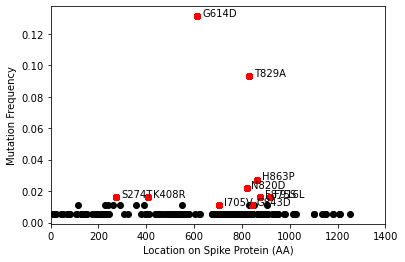

In [14]:
fig, ax = plt.subplots()
ax.scatter(spike_df.location,spike_df["surface glycoprotein"],color="black")
ax.set_xlim(0,1400)
ax.set_xlabel("Location on Spike Protein (AA)")
ax.set_ylabel("Mutation Frequency")
top_muts = spike_df.sort_values(by="surface glycoprotein",ascending=False)
for i,row in top_muts.iterrows():
    plt.text(row.location + 20,row["surface glycoprotein"],row.mutation_shorthand)
    ax.scatter(top_muts.location,top_muts["surface glycoprotein"],color="red")
plt.show()

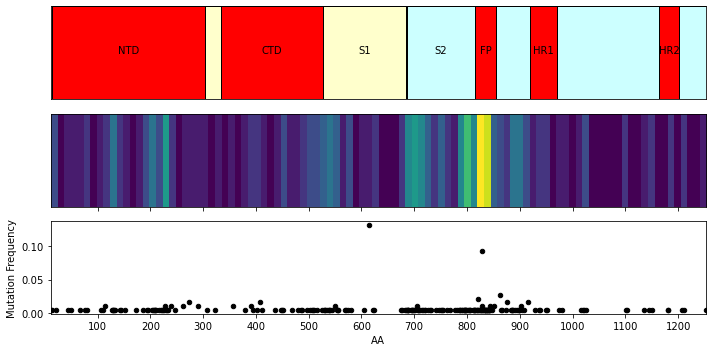

In [420]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = 10,5

x = top_muts.location.values
y = top_muts.mut_frequency.values
y_ = pd.cut(top_muts.location,bins=100).value_counts(sort=False).values

fig, (ax,ax2,ax3) = plt.subplots(nrows=3, sharex=True)
extent = [min(top_muts.location),max(top_muts.location),0,1]
ax2.imshow(y_[np.newaxis,:], cmap=cmap, aspect="auto", extent=extent)
ax2.set_yticks([])
ax2.set_xlim(extent[0],extent[1])

ax3.scatter(x,y,c="k",s=20)
ax3.set_xticks([i*100 for i in range(13)])
ax3.set_ylabel("Mutation Frequency")
ax3.set_xlabel("AA")

ax.set_xlim(extent[0],extent[1])
ax.set_ylim(extent[2],extent[3])
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



ax.add_patch(patches.Rectangle((13,0),672,1,facecolor="#FFFFCC",label="S2",edgecolor="k"))
ax.text(606,0.5,"S1",ha="center")
ax.add_patch(patches.Rectangle((686,0),587,1,facecolor="#CCFFFF",label="S1",edgecolor="k"))
ax.text(751,0.5,"S2",ha="center")

highlight_regions = [[13,303,"NTD"],[334,527,"CTD"],[816,855,"FP"],[920,970,"HR1"],[1163,1202,"HR2"]]
for highlight_region in highlight_regions:
    start,end,lbl = highlight_region
    patch = ax.add_patch(patches.Rectangle((start,0),end-start,1,facecolor="red",label=lbl,edgecolor="k"))
    centerx = start+(end-start)/2
    centery = 0.5
    ax.text(centerx,centery,lbl,ha="center")

plt.tight_layout()
plt.show()